In [1]:
import tensorflow as tf

c:\Users\ginny\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ginny\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\ginny\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#This section is for local GPU restrictions
physical_devices = tf.config.list_physical_devices('GPU') 

In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import  Dropout, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
train_path = 'Real_Life_Violence_Dataset/train_'
valid_path = 'Real_Life_Violence_Dataset/val_'
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(128,128), classes=['V_', 'NV_'], batch_size=16)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(128,128), classes=['V_', 'NV_'], batch_size=16)

Found 217307 images belonging to 2 classes.
Found 26472 images belonging to 2 classes.


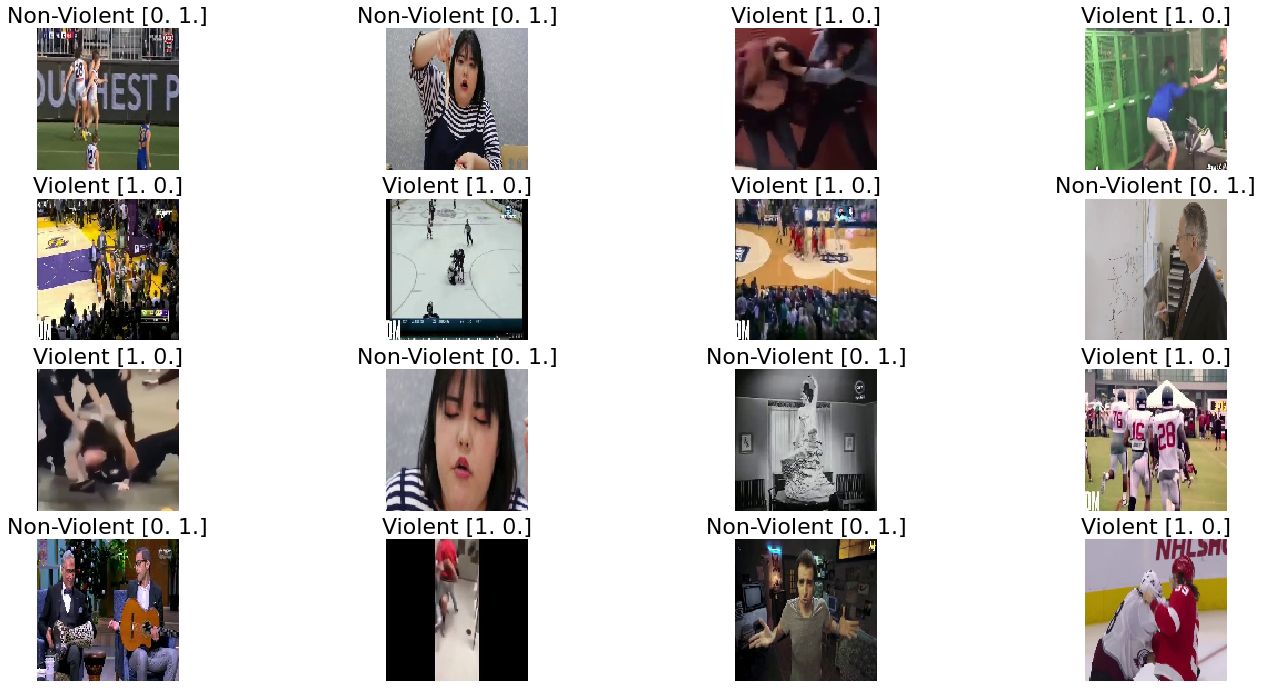

In [5]:
def plots(ims, figsize=(24,12), rows=4, interp=False, titles=None):
      if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
      f = plt.figure(figsize=figsize)
      cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
      for i in range(len(ims)):
          sp = f.add_subplot(rows, cols, i+1)
          sp.axis('Off')
          if titles is not None:
            if titles[i][0] == 1:
              sp.set_title("Violent "+str(titles[i]), fontsize=22)
            else:
              sp.set_title("Non-Violent "+str(titles[i]), fontsize=22)
          plt.imshow(ims[i], interpolation=None if interp else 'none')
imgs, labels = next(train_batches)
plots(imgs, titles=labels)




In [6]:
#VGG-16 model without the top (Fully-Connected Layer)
vgg16_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(128,128,3)))

In [7]:
#Freezing all the VGG-16 model layers except last 4
for layer in vgg16_model.layers[:-4]:
    layer.trainable = False

In [8]:
model = Sequential()
 
# Adding the vgg convolutional base model
model.add(vgg16_model)
 
# Adding new layers
model.add(tf.keras.layers.AveragePooling2D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 average_pooling2d (AverageP  (None, 2, 2, 512)        0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 14,845,954
Trainable params: 7,210,690
Non-trainable params: 7,635,264
_____________________________________

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_batches,
      steps_per_epoch=train_batches.samples/train_batches.batch_size ,
      epochs=3,
      validation_data=valid_batches,
      validation_steps=valid_batches.samples/valid_batches.batch_size,
      verbose=1)

Epoch 1/3
13581/13581 [==============================] - 11973s 881ms/step - loss: 0.0730 - acc: 0.9788 - val_loss: 0.4436 - val_acc: 0.9326
Epoch 2/3
13581/13581 [==============================] - 12175s 896ms/step - loss: 0.0052 - acc: 0.9985 - val_loss: 0.5010 - val_acc: 0.9418
Epoch 3/3
13581/13581 [==============================] - 12065s 888ms/step - loss: 0.0035 - acc: 0.9990 - val_loss: 0.5404 - val_acc: 0.9399


Text(0.5, 1.0, 'Accuracy')

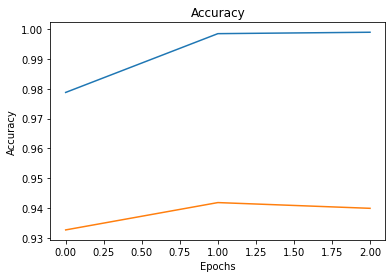

In [10]:
x1 = history.history['acc']
x2 = history.history['val_acc']
plt.plot(x1, label='Training Accuracy')
plt.plot(x2, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')

In [11]:
model.save('./model.pth')

INFO:tensorflow:Assets written to: ./model.pth\assets


INFO:tensorflow:Assets written to: ./model.pth\assets


In [12]:

import os
import shutil
import cv2
import numpy as np
import datetime
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import load_model

#Defining the paths
video = "Real_Life_Violence_Dataset/Violence/V_1.mp4" 
model_path = "./model.pth"
test_path = "./test/"
out_path = "./output/"

#Creating the test and output directory
os.mkdir(test_path)
os.mkdir(out_path)

vidcap = cv2.VideoCapture(video)
success,im = vidcap.read()
count = 0
while success:
    cv2.imwrite(test_path + "%d.jpg" %count, im)   # save frame as JPEG file      
    success,image = vidcap.read()
    count += 1

model = load_model(model_path)
files=[]
for i in os.listdir(test_path):
  files.append(int(i.split('.')[0]))
test_sorted = [str(i)+".jpg" for i in sorted(files)]

def my_predict(model, image_input, size):
    img = load_img(image_input, target_size=(size, size))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    result = model.predict(img, batch_size=1)
    return np.argmax(result)

SAMPLE_SIZE = 128
VIEW_SIZE = (600,400)

for files in test_sorted:
  filename = os.path.join(test_path, files)
  img = cv2.imread(filename)
  img = cv2.resize(img,(VIEW_SIZE[0],VIEW_SIZE[1]),interpolation = cv2.INTER_AREA)
  label = my_predict(model, filename, SAMPLE_SIZE)
  if not label:
    print("Violence Detected at:",datetime.datetime.now())
    font = cv2.FONT_HERSHEY_SIMPLEX
    img = cv2.putText(img,"Violence Detected",(5,25), font, 1,(255,255,255),2)
  cv2.imshow("Footage",img)
  cv2.imwrite(os.path.join(out_path, files),img)

  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
 
cv2.destroyAllWindows()

1/1 [==============================] - 0s 421ms/step
Violence Detected at: 2022-12-09 22:23:47.305039
1/1 [==============================] - 0s 97ms/step
Violence Detected at: 2022-12-09 22:23:47.614199
1/1 [==============================] - 0s 96ms/step
Violence Detected at: 2022-12-09 22:23:47.913524
1/1 [==============================] - 0s 78ms/step
Violence Detected at: 2022-12-09 22:23:48.143625
1/1 [==============================] - 0s 81ms/step
Violence Detected at: 2022-12-09 22:23:48.371387
1/1 [==============================] - 0s 78ms/step
Violence Detected at: 2022-12-09 22:23:48.594420
1/1 [==============================] - 0s 74ms/step
Violence Detected at: 2022-12-09 22:23:48.806020
1/1 [==============================] - 0s 115ms/step
Violence Detected at: 2022-12-09 22:23:49.121241
1/1 [==============================] - 0s 84ms/step
Violence Detected at: 2022-12-09 22:23:49.433425
1/1 [==============================] - 0s 89ms/step
Violence Detected at: 2022-12-09 22:2

In [ ]:
img_array = []
size_ = None
for filename in test_sorted:
    img = cv2.imread(os.path.join(out_path,filename))
    height, width, layers = img.shape
    size = (width,height)
    size_ = size
    img_array.append(img)
 
out = cv2.VideoWriter('output_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size_)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

#Deleting created image frames:
shutil.rmtree(out_path)
shutil.rmtree(test_path)